# Imports

In [ ]:
import numpy as np
from scipy.special import expit   # sigmoid

import math
import numpy as np
import matplotlib.pyplot as plt
from time import time

import torch
from torchvision import datasets, transforms
import itertools
import pandas as pd


In [ ]:

#%matplotlib inline
from IPython.display import display, Markdown, Latex, Math, Pretty

from timeit import timeit
from numpy.random import rand, randint

# change some of the defaults for plots
plt.rcParams['text.usetex'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.figsize'] = [18,6]
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14


# Introduction to The Ising Model

The **Ising model** is a fundamental model in statistical mechanics used to describe phase transitions in systems of interacting spins. Each spin can take on one of two values: $+1$ or $-1$, representing spin-up or spin-down. The spins interact with their nearest neighbors on a lattice, and the model is typically studied on two-dimensional or three-dimensional lattices.In the Ising model, each spin at lattice site $i$ can take one of two possible values:$
\sigma_i = \pm 1 $. Thus, the spin is discrete, with $+1$ representing "spin up" and $-1$ representing "spin down."

The **Hamiltonian** $H$ of the Ising model describes the total energy of a given configuration of spins. It includes contributions from the interactions between neighboring spins and possibly an external magnetic field. The Hamiltonian is given by:

$$
H = -J \sum_{\langle i,j \rangle} \sigma_i \sigma_j - h \sum_i \sigma_i
$$

Where:
- $\langle i,j \rangle$ denotes a sum over nearest-neighbor pairs of spins on a lattice.
- $J$ is the **coupling constant**, which determines the strength of the interaction between neighboring spins.
  - $J > 0$ corresponds to **ferromagnetic** interactions (favoring aligned spins).
  - $J < 0$ corresponds to **antiferromagnetic** interactions (favoring anti-aligned spins).
- $\sigma_i$ is the spin at site $i$, taking values $+1$ or $-1$.
- $h$ is an external magnetic field (optional), which tends to align the spins either up or down, depending on its sign.


In the absence of an external magnetic field ($h = 0$), the Hamiltonian simplifies to:

$$
H = -J \sum_{\langle i,j \rangle} \sigma_i \sigma_j
$$

Here, the system's energy is minimized when neighboring spins are aligned ($\sigma_i = \sigma_j$).


In statistical mechanics, the partition function $Z$ is used to calculate thermodynamic properties of the system. For the Ising model, the partition function is given by:

$$
Z = \sum_{\{\sigma_i\}} e^{-\beta H}
$$

Where:
- $H$ is the Hamiltonian of the system.
- $\beta = \frac{1}{k_B T}$ is the inverse temperature (with $k_B$ being the Boltzmann constant and $T$ the temperature).
- The sum is over all possible configurations of spins $\sigma_i$.

The partition function is crucial for determining quantities such as the **free energy**, **magnetization**, and **specific heat**.

Using the partition function $Z$, various thermodynamic quantities can be calculated:

- **Free Energy**:
  $$
  F = -k_B T \ln Z
  $$

- **Magnetization**:
  The magnetization $M$ measures the degree of alignment of the spins and is given by:
  $$
  M = \frac{1}{N} \sum_i \sigma_i
  $$
  Where $N$ is the total number of spins in the system. The magnetization is maximal when all spins are aligned.

- **Specific Heat**:
  The specific heat $C$ measures how the energy of the system changes with temperature:
  $$
  C = \frac{1}{k_B T^2} \left( \langle H^2 \rangle - \langle H \rangle^2 \right)
  $$

- **Correlation Function**:
  The correlation function $G(r)$ describes how the spin at one site is correlated with the spin at another site a distance $r$ away:
  $$
  G(r) = \langle \sigma_i \sigma_j \rangle
  $$
  Where $\langle \cdot \rangle$ denotes the thermal average. This function decays as $r$ increases and provides information about the long-range order in the system.

The Ising model exhibits a **phase transition** between an ordered and disordered phase, depending on the temperature:

- **High temperature (disordered phase)**: At high temperatures, thermal fluctuations dominate, and the spins are disordered, with no net magnetization. The correlation function $G(r)$ decays exponentially with distance, indicating a lack of long-range order.
  
- **Low temperature (ordered phase)**: At low temperatures, the system exhibits **spontaneous magnetization**. In this phase, most of the spins align in the same direction, and the system exhibits long-range order. The correlation function decays slowly, and there is a nonzero magnetization.

- **Critical temperature**: At a specific temperature $T_c$, the system undergoes a second-order phase transition. Near this critical point, the correlation length diverges, and the system exhibits **scale invariance**.


# Ising Model for N = 6

A very good way to gain intuition about the Ising Model is to solve it for a simpler system for which the partition function is tractable. The advantage of this being that we can verify that our next methods such as MCMC and RBM model that will be trained on top of it is working it. We will consider solving the system exactly for N = 6 case because that is solved exactly in the paper, "*"Learning Thermodynamics with Boltzmann Machines"* by Giacomo Torlai and Roger.

Assuming periodic boundary conditions, the Hamiltonian assumes the following form for N = 6 (J = 1):

$$H_s = \sigma_{1}\sigma_{2} + \sigma_{2}\sigma_{3} + \sigma_{3}\sigma_{4} + \sigma_{4}\sigma_{5} + \sigma_{5}\sigma_{6} + \sigma_{6}\sigma_{1} $$

Keep in mind that configurations where all spins are aligned lead to lower energies are more likey and vice-versa. We would like to solve this system exactly. For that, we need to evaluate the partition function $Z = \sum_{\sigma}{e^{H(\sigma)/T}} $. For N = 6 states, there are a total of $2^{N} = 64$ combinations possible. We now find these exactly.

**Binarizing the Data**: We would be binarizing our data in some places in the code to transform our vectors from {-1, +1} to {0,1}. The reason for this binarization is primarily because our RBM is built to handle data in the region {0,1}

In [ ]:
## Boltzmann Distribution for a Spin System

# Define parameters
N = 6  # Number of spins
J = 1  # Coupling constant
T = 1  # Temperature

# Generate all possible spin configurations (-1, 1 for each spin)
configurations = list(itertools.product([-1, 1], repeat=N))
print(configurations[1])
print(len(configurations)) # 64 configurations possible.

(-1, -1, -1, -1, -1, 1)
64


In [ ]:
# Hamiltonian function for 1D Ising model with periodic boundary conditions

# The function loops through each spin in the configuration.
# For each spin 𝜎_{𝑖} , it multiplies it by its nearest neighbor 𝜎_{i+1}
# The expression config[(i + 1) % N] ensures that when i is at the last spin in
# the chain, it wraps around to the first spin (periodic boundary condition)


def hamiltonian_periodic(config, J):
    energy = 0
    for i in range(len(config)):
        energy += config[i] * config[(i + 1) % N]  # Periodic boundary condition
    return -J * energy

def hamiltonian_non_periodic(config, J):
    energy = 0
    N = len(config)  # Length of the spin configuration
    for i in range(N - 1):  # No interaction between the last and the first spin
        energy += config[i] * config[i + 1]
    return -J * energy


# Example configuration and parameters
config = [-1, 1, -1, 1, -1, 1]  # Example spin configuration
J = 1  # Coupling constant

# Call the hamiltonian function
energy = hamiltonian_non_periodic(config, J)

# Output the energy
print(f"Energy of the configuration {config} is {energy}")

Energy of the configuration [-1, 1, -1, 1, -1, 1] is 5


In [ ]:
# Initialize lists for energies and Boltzmann factors
energies = []
boltzmann_factors = []

# Loop over each configuration
for config in configurations:
    # Compute the energy for the current configuration
    energy = hamiltonian_periodic(config, J)

    # Append the energy to the list
    energies.append(energy)

    # Compute the Boltzmann factor for the current energy
    boltzmann_factor = np.exp(-energy / T)

    # Append the Boltzmann factor to the list
    boltzmann_factors.append(boltzmann_factor)

# Convert lists to arrays for further computation (if needed)
energies = np.array(energies)
boltzmann_factors = np.array(boltzmann_factors)

In [ ]:
# Partition function Z
Z = np.sum(boltzmann_factors)

# Boltzmann probabilities for each configuration
probabilities = boltzmann_factors / Z

# Organize the result for better readability
results = []
for config, energy, prob in zip(configurations, energies, probabilities):
    results.append((config, energy, prob))

import pandas as pd
df = pd.DataFrame(results, columns=['Configuration', 'Energy', 'Boltzmann Probability'])

print(df)


               Configuration  Energy  Boltzmann Probability
0   (-1, -1, -1, -1, -1, -1)      -6               0.390694
1    (-1, -1, -1, -1, -1, 1)      -2               0.007156
2    (-1, -1, -1, -1, 1, -1)      -2               0.007156
3     (-1, -1, -1, -1, 1, 1)      -2               0.007156
4    (-1, -1, -1, 1, -1, -1)      -2               0.007156
..                       ...     ...                    ...
59       (1, 1, 1, -1, 1, 1)      -2               0.007156
60      (1, 1, 1, 1, -1, -1)      -2               0.007156
61       (1, 1, 1, 1, -1, 1)      -2               0.007156
62       (1, 1, 1, 1, 1, -1)      -2               0.007156
63        (1, 1, 1, 1, 1, 1)      -6               0.390694

[64 rows x 3 columns]


### Plotting the 1D ising model for N = 6

**Confusion** In the paper, the authors have shown the probabilities associated with degenerate states to be different and not equally likely. Is that a mistake or am I missing something? In particular, see figure 2B.


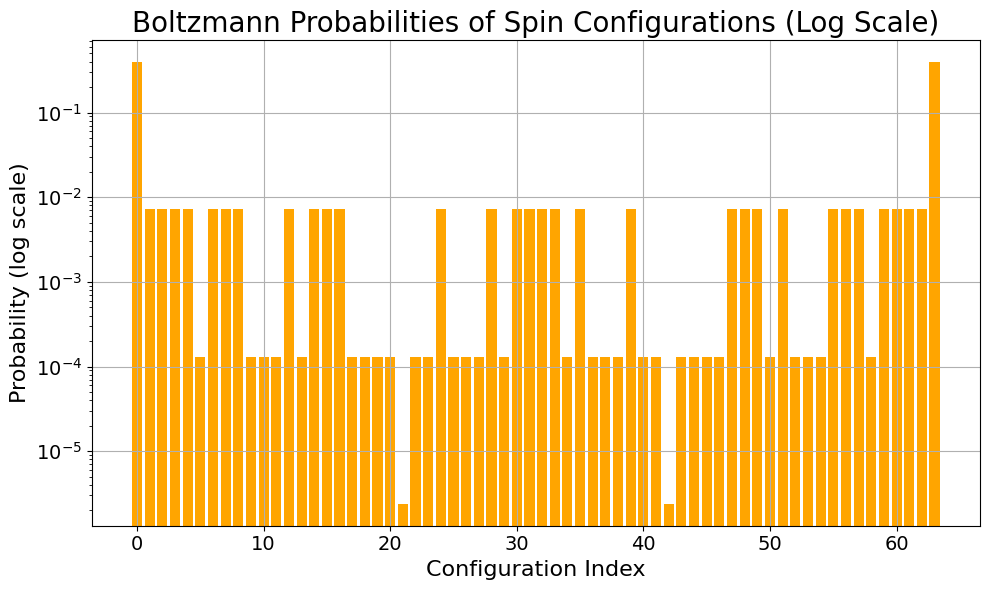

In [ ]:
# Plot the energies and corresponding Boltzmann probabilities on a log scale
plt.figure(figsize=(10, 6))

# Plot Boltzmann probabilities
plt.subplot(1, 1, 1)
plt.bar(range(len(probabilities)), probabilities, color='orange')
plt.yscale('log')  # Logarithmic scale for the probabilities
plt.title('Boltzmann Probabilities of Spin Configurations (Log Scale)')
plt.ylabel('Probability (log scale)')
plt.xlabel('Configuration Index')

# Show the plot
plt.tight_layout()
plt.show()

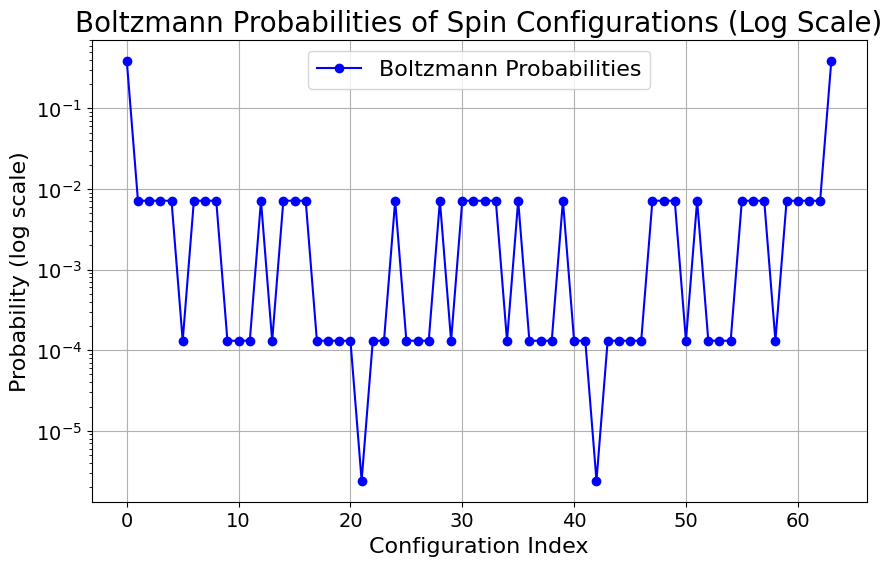

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate configuration indices (0 to 63 for N=6)
config_indices = range(len(configurations))

# Plotting the probabilities on a logarithmic scale
plt.figure(figsize=(10, 6))

# Plot the probabilities as a line plot
plt.plot(config_indices, probabilities, marker='o', linestyle='-', color='blue', label='Boltzmann Probabilities')

# Set y-axis to logarithmic scale
plt.yscale('log')

# Labeling the plot
plt.title('Boltzmann Probabilities of Spin Configurations (Log Scale)')
plt.xlabel('Configuration Index')
plt.ylabel('Probability (log scale)')

# Show the legend
plt.legend()

# Show the plot
plt.show()

# MCMC Methods for Ising Model

Our aim is to approximate the underlying distribuition $P = \frac{1}{Z} e^{-\beta{H(\sigma)}}$ using MCMC so we can draw samples from it which would subsequently would be utilized for training our RBM. Basically, we would run the MCMC for a sufficiently long time (so the system reaches thermal equilibrium). After this, the configurations we will observe will be distributed according to $P = \frac{1}{Z} e^{-\beta{H(\sigma)}}$.

1.  **Initialize**: Start with a spin configuration $ \sigma^{(0)} $.
2. Choose a site $ i $ uniformly at random from the lattice.
3. Compute the change in energy $ \Delta E $ associated with flipping $ \sigma_i $. $ \Delta E = 2J \sigma_i \sum_{j \in \mathcal{N}_i} \sigma_j$
4. Acceptance Probability:
  - If $ \Delta E \leq 0 $, accept the flip.
  - If $ \Delta E > 0 $, accept the flip with probability $ P_{\text{accept}} = e^{-\beta \Delta E} $
5. If the flip is accepted, update the configuration:$ \sigma_i \rightarrow -\sigma_i$
6. If rejected, keep the configuration unchanged.
7. Repeat steps 2–5 for $ N_{\text{steps}} $ iterations.


*Example* : Suppose we begin with the spin configuration $ \sigma = [+1, -1, +1, -1] $. The **initial energy** of the system using the Hamiltonian: $H(\sigma) = -J (\sigma_1 \sigma_2 + \sigma_2 \sigma_3 + \sigma_3 \sigma_4)
$ is $ H(\sigma) = 3 $. Suppose we randomly select spin $ \sigma_2 $ (the second spin, which is currently $-1$ to flip. The new proposed configuration after the flip would be $ \sigma' = [+1, +1, +1, -1] $ where now $ \sigma_2 = +1 $. The change in energy $ \Delta E $ due to flipping spin $ \sigma_2 $ is calculated by looking at the **energy before and after the flip**. Before the flip, the local contribution to the energy from spins $ \sigma_1 $, $ \sigma_2 $, and $ \sigma_3 $ is $H_{\text{before}} = -J (\sigma_1 \sigma_2 + \sigma_2 \sigma_3) $. Substituting values:

$$ H_{\text{before}} = -1 (+1 \cdot -1 + -1 \cdot +1) = -1 (-1 - 1) = 2 $$

After the flip, the contribution to the energy from spins $ \sigma_1 $, $ \sigma_2 $, and $ \sigma_3 $ is $ H_{\text{after}} = -J (\sigma_1 \sigma_2' + \sigma_2' \sigma_3) $. Substituting the new values:

$$
H_{\text{after}} = -1 (+1 \cdot +1 + +1 \cdot +1) = -1 (1 + 1) = -2
$$

Now we can compute the total energy change $ \Delta E $:

$$
\Delta E = H_{\text{after}} - H_{\text{before}} = -2 - 2 = -4
$$

According to the **Metropolis criterion**:
- If $ \Delta E \leq 0 $, we **always accept** the flip because it lowers the system's energy.
- If $ \Delta E > 0 $, we accept the flip with probability $ P_{\text{accept}} = e^{-\beta \Delta E} $.

In our case, since $ \Delta E = -4 \leq 0 $, the spin flip is accepted **unconditionally** because it reduces the system’s energy. Since the spin flip is accepted, we update the configuration to $ \sigma' = [+1, +1, +1, -1] $

After many iterations, the system will have visited enough spin configurations to approximate the equilibrium distribution, and you can calculate thermodynamic properties like **magnetization**, **correlation**, etc.


### Energy E & Magnetization of Ising Model

We calculate the energy and magnetization of some sample Ising model configurations.
For J > 0, Spins tend to align in the same direction, leading to a higher magnetization (either all +1 or all −1), and the energy is minimized when neighboring spins are aligned $ \sigma_𝑖 = \sigma_𝑖+1 $. In this case, the magnetization is high, and the energy is low due to favorable spin alignment. Therefore in equilibrium, the magnetization is high. Now in some cases, the magnetization is divided by total number of spins and in some cases its not. I am gonna with the undivided case.


In [ ]:
'''
Functions to calculate Energy (E) and Magnetic Moment (M) of the L*L spin lattice
Particles at the edge of the lattice rollover for adjacent calculation using periodic boundary conditions through np.roll
'''
"""
def energy( s ) :
    # this is the energy for each site
    E = -J * ( s * np.roll( s, 1 ) )
    # and this is the avg energy per site
    return np.sum( E ) / L
"""

def energy(spin):
    """
    Computes the total energy of a 1D Ising model spin configuration using lists.

    Parameters:
    - spin: List of spins (+1 or -1)
    - J: Coupling constant

    Returns:
    - Total energy as a single-element list
    """
    N = len(spin)

    # Compute interaction energy between each spin and its right neighbor with periodic boundary conditions
    interaction_energy = 0
    for i in range(N):
        right = (i + 1) % N  # Right neighbor with periodic boundary
        interaction_energy += -J * spin[i] * spin[right]  # Interaction energy with right neighbor

    return interaction_energy  # Return the result as a list


# Metropolis and Ising Model Functions
#def d_energy_1D(spin, x, J):
#    N = spin.shape[0]
#    left = np.mod(x - 1, N)
#    right = np.mod(x + 1, N)
#    de = -J * (-spin[x] * spin[left] - spin[x] * spin[right])
#    return de



#Simple sum over spin of all particles
def magnetization( s ) :
    return np.sum( s )

s1 = [1, 1, 1, 1]
s2 = [1, -1, 1, -1]
s3 = [1, 1, -1, -1]
s4 = [-1, 1, -1, 1]
s5 = [-1, -1, -1, -1]
J = 1
L = 4

print(f"Energy for s1: {energy(s1)}")
print(f"Magnetization for s1: {magnetization(s1)}")
print(f"Energy for s2: {energy(s2)}")
print(f"Magnetization for s2: {magnetization(s2)}")
print(f"Energy for s3: {energy(s3)}")
print(f"Magnetization for s3: {magnetization(s3)}")
print(f"Energy for s4: {energy(s4)}")
print(f"Magnetization for s4: {magnetization(s4)}")
print(f"Energy for s5: {energy(s5)}")
print(f"Magnetization for s5: {magnetization(s1)}")


Energy for s1: -4
Magnetization for s1: 4
Energy for s2: 4
Magnetization for s2: 0
Energy for s3: 0
Magnetization for s3: 0
Energy for s4: 4
Magnetization for s4: 0
Energy for s5: -4
Magnetization for s5: 4


In [ ]:

#Creates an LxL lattice of random integer spins with probability (p) to be +1 (and 1-p to be -1)
def randomLattice( L, p ) :
    return ( rand( L ) < p ) * 2 - 1


In [ ]:
p = 0.5          #probability for each particle to be spin-up (+1)
L = 100          # lattice size is L
J = 1.0          # gauge coupling parameter
kB = 1.0         # the Boltzman constant

#Demonstration of simple case (50/50 up-down spin distribution) and extreme cases (all spins up or down)
    #showing their associated energy and magnetic moments
spinLattice = randomLattice( L, p )
print('\n50/50 up/down spin lattice:')
print( spinLattice )
print( 'Energy = %3.2f' % energy( spinLattice ) )
print( 'Magnetization = %3.2f' % magnetization( spinLattice ) )



50/50 up/down spin lattice:
[ 1 -1  1 -1 -1  1 -1 -1  1  1  1  1 -1 -1  1 -1 -1 -1 -1  1  1 -1  1 -1
  1 -1  1  1 -1  1  1  1  1  1  1  1  1 -1 -1  1 -1  1 -1 -1 -1 -1  1  1
  1 -1  1  1  1 -1 -1 -1 -1  1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1  1
  1  1 -1 -1 -1 -1 -1  1 -1  1 -1 -1  1  1  1 -1  1 -1  1 -1 -1  1  1 -1
  1 -1  1  1]
Energy = 0.00
Magnetization = 8.00


In [ ]:
spinLattice = randomLattice( L, 1 )
print('\nUp spin lattice:')
print( spinLattice )
print( 'Energy = %3.2f' % energy( spinLattice ) )
print( 'Magnetization = %3.2f' % magnetization( spinLattice ) )


Up spin lattice:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Energy = -100.00
Magnetization = 100.00


In [ ]:
spinLattice = randomLattice( L, 0 )
print('\n Down spin lattice')
print( spinLattice )
print( 'Energy = %3.2f' % energy( spinLattice ) )
print( 'Magnetization = %3.2f' % magnetization( spinLattice ) )


 Down spin lattice
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1]
Energy = -100.00
Magnetization = -100.00


## Defining the metropolis algorithm

In [ ]:

def metropolis( s, T ) :
    '''
    This runs the Metropolis algorithm for one unit of "Monte Carlo
    time (MCT)", defined as N steps where N is the number of items in the
    ensemble. In this case this is L*L.
    '''
    L = len( s )
    oldE = energy( s )
    #print("old energy ", oldE)
    for n in range( L ) : # this loop is 1 MCT

        # flip a random spin and calculate deltaE
        i = randint( L )
        s[i] *= -1    # flip the i-th spin

        newE = energy( s )
        #print("new energy ", newE)
        deltaE = newE - oldE

        # these are the Metropolis tests
        if deltaE < 0 :
            oldE = newE
            # keep the flipped spin because it lowers the energy
        elif rand( ) < np.exp(  - deltaE / ( kB * T ) ) :
            #print("old E" , oldE, "prb ", np.exp(  - deltaE / ( kB * T )) )
            oldE = newE
            # keep the spin flip because a random number in [0,1)
            # is less than exp( -dE / k_B T)
        else :
            # the spin flip is rejected
            s[i] *= -1    # unflip the ij spin

    return s



In [ ]:
n = 1000                           # the number of MCT steps
p = 0.5                             # probability for the initial random lattice
T = 1 * J / kB                    # temp of the system in terms of coupling parameter and boltzmann constant
E = np.zeros( n )
M = np.zeros( n )
spinLattice = randomLattice( L, p )

#Run metropolis algo for N time steps and record energy, magnetic moments of each random lattice config
for i in range( n ) :
    spinLattice = metropolis( spinLattice, T )
    M[i] = magnetization( spinLattice )
    E[i] = energy( spinLattice )
    #print("energy is ", E[i])


## P(E) against E

For now, I set 5000 as the no. of samples it take to equilibriate and then only calculate 1000 next for sampling.

system equilibriated


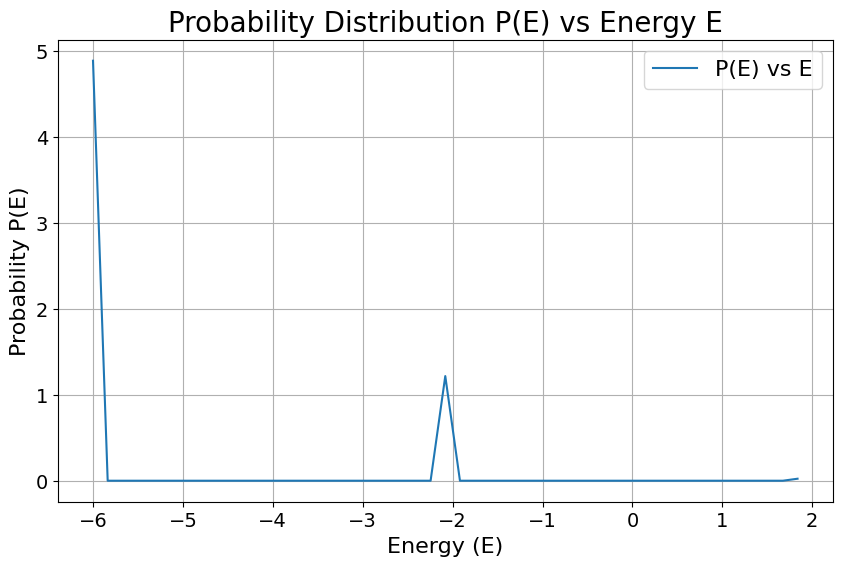

In [ ]:
p = 0.5          #probability for each particle to be spin-up (+1)
L = 6           # to see if the method is working for n = 6 for which we have
                 # the analytical case
J = 1.0          # gauge coupling parameter
kB = 1.0         # the Boltzman constant

n_equilibrate =  5000  # Number of steps for equilibration
n_samples = 10000      # Number of samples after equilibration

# Update the size of E and M to match the number of samples
E = np.zeros(n_samples)
M = np.zeros(n_samples)

# Equilibrate the system
spinLattice = randomLattice(L, p)
for _ in range(n_equilibrate):
    spinLattice = metropolis(spinLattice, T)

print("system equilibriated")

# Take samples after equilibration
for i in range(n_samples):
    spinLattice = metropolis(spinLattice, T)
    M[i] = magnetization(spinLattice)
    E[i] = energy(spinLattice)


# Probability distribution of P(E) against E

# Define bin edges for histogram
bins = np.linspace(min(E), max(E), 50)

# Create histogram for energy (P(E))
hist, bin_edges = np.histogram(E, bins=bins, density=True)

# Plot the probability distribution P(E) against energy E
plt.figure(figsize=(10, 6))
plt.plot(bin_edges[:-1], hist, label='P(E) vs E')
plt.xlabel('Energy (E)')
plt.ylabel('Probability P(E)')
plt.title('Probability Distribution P(E) vs Energy E')
plt.grid(True)
plt.legend()
plt.show()

## P(configuration) vs Configurations

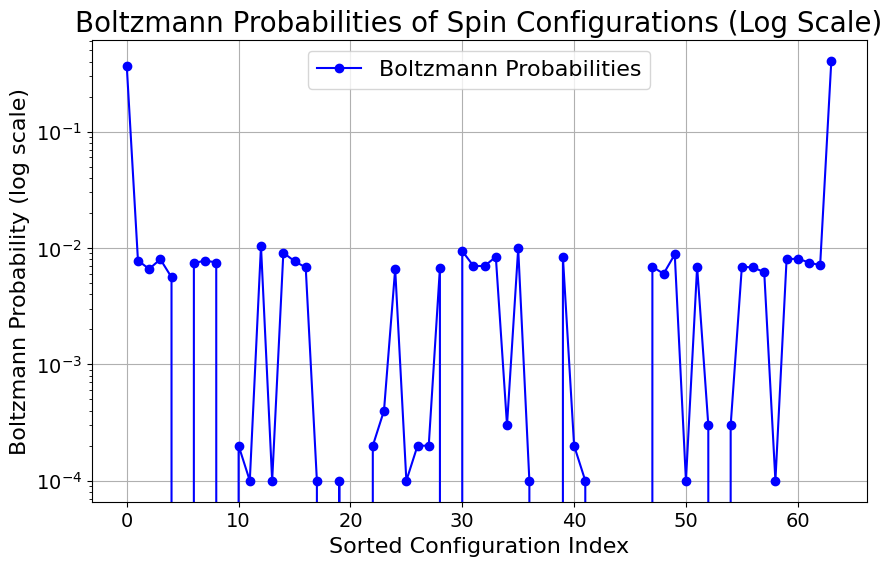

In [ ]:

# Parameters
L = 6  # Example lattice size
T = 1.0  # Example temperature
n_equilibrate = 20000  # Number of steps for equilibration
n_samples = 10000  # Number of samples after equilibration


# Record occurrences of each configuration
configurations = defaultdict(int)

# Equilibrate the system
p = 0.5
spinLattice = randomLattice(L, p)
for _ in range(n_equilibrate):
    spinLattice = metropolis(spinLattice, T)

# Take samples after equilibration
for _ in range(n_samples):
    spinLattice = metropolis(spinLattice, T)
    # Convert configuration to a tuple to store as key
    config_tuple = tuple(spinLattice)
    configurations[config_tuple] += 1

# Convert to probability
total_configurations = sum(configurations.values())
probabilities = {config: count / total_configurations for config, count in configurations.items()}

# Print configurations and their probabilities
#for config, prob in probabilities.items():
#    print(f"Configuration: {config}, Probability: {prob}")

# Ensure that the configurations in the dataframe are in the same format as those in probabilities
df['Configuration'] = df['Configuration'].apply(tuple)

# Now reorder the 'probabilities' based on the configuration order in df, handling missing cases
sorted_probabilities = [probabilities.get(config, 0) for config in df['Configuration']]

# Plot sorted probabilities based on the sorted DataFrame
plt.figure(figsize=(10, 6))
plt.plot(range(len(sorted_probabilities)), sorted_probabilities, marker='o', linestyle='-', color='blue', label='Boltzmann Probabilities')

# Set y-axis to logarithmic scale and limits from 10^-1 to 10^-5
plt.yscale('log')

# Labeling the plot
plt.title('Boltzmann Probabilities of Spin Configurations (Log Scale)')
plt.xlabel('Sorted Configuration Index')
plt.ylabel('Boltzmann Probability (log scale)')

# Show the legend
plt.legend()

# Show the plot
plt.show()

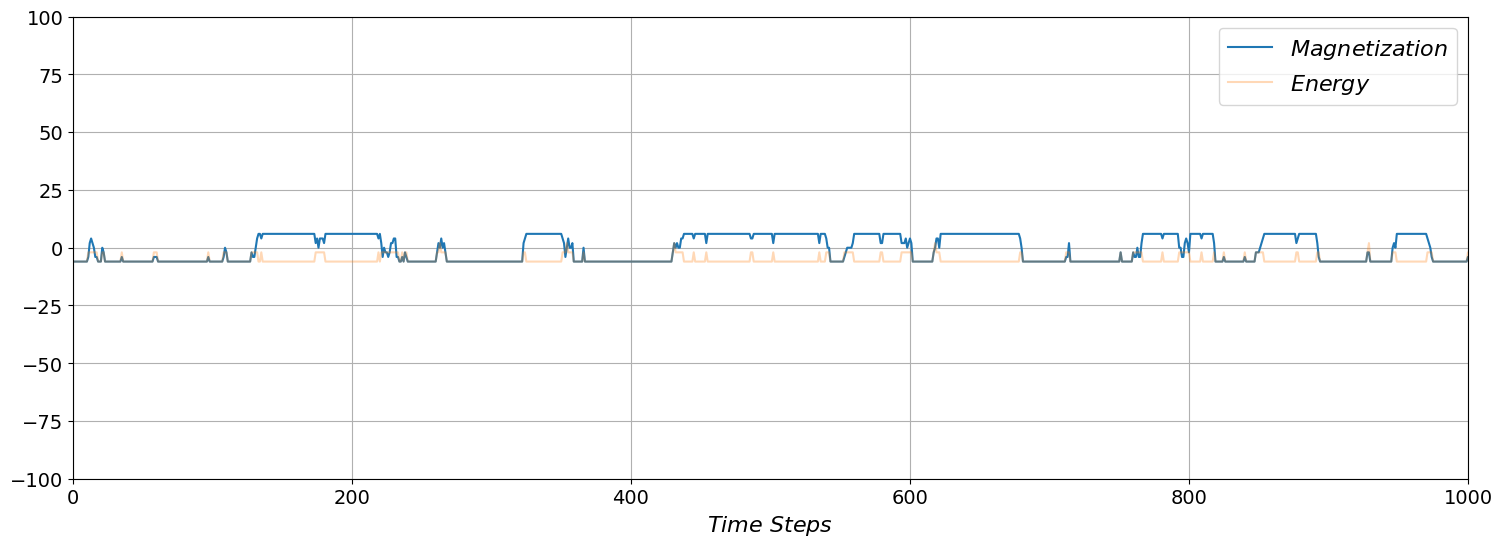

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [ ]:
#Visualize with a plot the markov chain which represents the spin lattice probability distribution
#The equilibrium configuration in the markov chain should be at minimal energy and magnetic moment 0
plt.plot( M, label='$Magnetization$' )
plt.plot( E, label='$Energy$', alpha=0.3 )

plt.xlabel( '$Time$' + ' ' + '$Steps$' )
plt.axis( [0,n,-100,+100] )
plt.legend( )
plt.show()

#show that the markov chain indeed has an equilibrium configuration at minimized energy and zero magnetization,
#taking the average of Energy/Magnetization as well as the deviation from equilibrium of visited random lattice configurations
display( Latex ( r'$Energy= %6.5f \pm %6.5f$'
               %
               ( np.average(E), np.std(E, ddof=1) ) )
       )
display( Latex( r'$Magnetization= %6.5f \pm %6.5f$'
               %
               ( np.average(M), np.std(M, ddof=1) ) )
       )



# Ising RBM

In [ ]:
import numpy as np
from scipy.special import expit

class RBM():
    def __init__(self, n_vis=6, n_hid=100):
        self.n_vis = n_vis # visible_units
        self.n_hid = n_hid # hidden units
        # Parameters
        self.W = 0.1 * np.random.randn(n_vis, n_hid) # W_ij connects visible
                                                     # $& hidden units
        self.vbias = np.zeros(n_vis)
        self.hbias = -4.0 * np.ones(n_hid)

        # Gradients
        self.W_grad = np.zeros(self.W.shape)
        self.vbias_grad = np.zeros(n_vis)
        self.hbias_grad = np.zeros(n_hid)

        # Velocities - for momentum
        self.W_vel = np.zeros(self.W.shape)
        self.vbias_vel = np.zeros(n_vis)
        self.hbias_vel = np.zeros(n_hid)

    def h_given_v(self, v):
        '''
        input:
            - v: (batch_size, n_vis)
        output:
            - p(H|v) = sigmoid(W^Tv + hbias): (batch_size, n_hid)
            - samples from p(H|v): (batch_size, n_hid)
        '''
        p = expit(np.matmul(v, self.W) + self.hbias)
        return (p, np.random.binomial(1, p=p))

    def v_given_h(self, h):
        '''
        input:
            - h: (batch_size, n_hid)
        output:
            - p(V|h) = sigmoid(Wh + vbias): (batch_size, n_vis)
            - samples from p(V|h): (batch_size, n_vis)
        '''
        p = expit(np.matmul(h, self.W.T) + self.vbias)
        return (p, np.random.binomial(1, p=p))

    def compute_error_and_grads(self, batch, burn_in=0, num_steps=5, method="cd"):
        '''
        Function to compute the gradient of parameters and store in param_grad variables
        and reconstruction error.
        Implements CD-k with k = num_steps.
        input:
            - batch: (batch_size, n_vis)
            - burn_in: Number of burn in steps for Gibbs sampling
            - num_steps: Number of steps for Gibbs sampling chain to run (CD-k)
            - method: Method for computing gradients. Available options:
                    - "cd": Contrastive Divergence
        output:
            - recon_error: Reconstruction error
        '''
        b_size = batch.shape[0]
        v0 = batch.reshape(b_size, -1)

        # Positive Phase
        ph0, h0 = self.h_given_v(v0)

        W_grad = np.matmul(v0.T, ph0)  # Positive gradient term
        vbias_grad = np.sum(v0, axis=0)
        hbias_grad = np.sum(ph0, axis=0)

        # Negative Phase (CD-k with k = num_steps)
        pv = v0
        for _ in range(num_steps):
            ph, h = self.h_given_v(pv)  # Hidden given visible
            pv, v = self.v_given_h(ph)  # Visible given hidden

        # After k Gibbs steps
        phk, hk = self.h_given_v(pv)

        # Negative gradient term
        W_grad -= np.matmul(pv.T, phk)

        # Convert both to float64 before subtraction
        vbias_grad = vbias_grad.astype(np.float64)
        vbias_grad -= np.sum(pv.astype(np.float64), axis=0)

        hbias_grad = hbias_grad.astype(np.float64)
        hbias_grad -= np.sum(phk.astype(np.float64), axis=0)

        # Normalize gradients
        self.W_grad = W_grad / b_size
        self.hbias_grad = hbias_grad / b_size
        self.vbias_grad = vbias_grad / b_size

        # Reconstruction error (sum of squared errors)
        recon_err = np.mean(np.sum((v0 - pv) ** 2, axis=1), axis=0)
        return recon_err

    def update_params(self, lr, momentum=0):
        '''
        Function to update the parameters based on the stored gradients.
        input:
            - lr: Learning rate
            - momentum
        '''
        self.W_vel *= momentum
        self.W_vel += (1.-momentum) * lr * self.W_grad
        self.W += self.W_vel

        self.vbias_vel *= momentum
        self.vbias_vel += (1.-momentum) * lr * self.vbias_grad
        self.vbias += self.vbias_vel

        self.hbias_vel *= momentum
        self.hbias_vel += (1.-momentum) * lr * self.hbias_grad
        self.hbias += self.hbias_vel

    def reconstruct(self, v):
        '''
        Reconstructing visible units from given v.
        v -> h0 -> v1
        input:
            - v: (batch_size, n_vis)
        output:
            - prob of reconstructed v: (batch_size, n_vis)
        '''
        ph0, h0 = self.h_given_v(v)
        pv1, v1 = self.v_given_h(ph0)
        return pv1

    def avg_free_energy(self, v):
        '''
        Compute the free energy of v averaged over the batch.
        input:
            - v: (batch_size, n_vis)
        output:
            - average of free energy: where free energy = - v.vbias - Sum_j (log(1 + exp(hbias + v_j*W_:,j)) )
        '''
        x = self.hbias + np.matmul(v, self.W)
        free_energy_batch = -np.matmul(v, self.vbias) - np.sum(np.log(1 + np.exp(x)), axis=1)
        return np.mean(free_energy_batch)

    def gen_model_sample(self, start=None, num_iters=1000):
        '''
        Generate random samples of visible unit from the model using Gibbs sampling.
        input:
            - start: Any starting value of v.
            - num_iters: Number of iterations of Gibbs sampling.
        '''
        if(start is None):
            v = np.random.randn(self.n_vis)
        else:
            v = start
        for _ in range(num_iters):
            ph, h = rbm.h_given_v(v)
            pv, v = rbm.v_given_h(h)
        return v

## Binarizing the Data

Since our RBM accepts data from {0,1}. Thus, we must transform the above from {-1,+1} to {0,1}

In [ ]:
from sklearn.preprocessing import Binarizer  # Import the Binarizer

# Extract the Configuration column as a numpy array
configurations = np.array(df['Configuration'].tolist())

# Binarize the Configuration column (convert -1 to 0 and leave 1 as it is)
binarizer = Binarizer(threshold=0.0)
binary_configurations = binarizer.fit_transform(configurations)

# Replace the Configuration column in the DataFrame with the binarized configurations
df['Configuration'] = list(binary_configurations)

# Print the updated DataFrame
print(df)

         Configuration  Energy  Boltzmann Probability
0   [0, 0, 0, 0, 0, 0]      -6               0.390694
1   [0, 0, 0, 0, 0, 1]      -2               0.007156
2   [0, 0, 0, 0, 1, 0]      -2               0.007156
3   [0, 0, 0, 0, 1, 1]      -2               0.007156
4   [0, 0, 0, 1, 0, 0]      -2               0.007156
..                 ...     ...                    ...
59  [1, 1, 1, 0, 1, 1]      -2               0.007156
60  [1, 1, 1, 1, 0, 0]      -2               0.007156
61  [1, 1, 1, 1, 0, 1]      -2               0.007156
62  [1, 1, 1, 1, 1, 0]      -2               0.007156
63  [1, 1, 1, 1, 1, 1]      -6               0.390694

[64 rows x 3 columns]


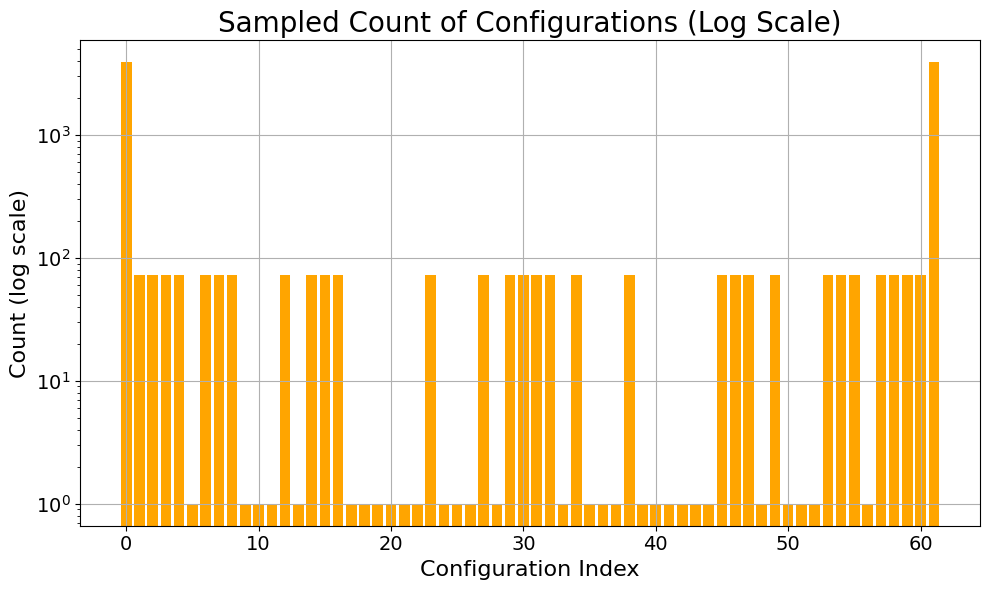

In [ ]:
from collections import Counter

# Total number of samples we want
num_samples = 10000

# Replicate each configuration proportional to its Boltzmann probability
df['Cloned Count'] = (df['Boltzmann Probability'] * num_samples).round().astype(int)

# Create a new list of configurations based on these counts
sampled_configs = []
for idx, row in df.iterrows():
    sampled_configs.extend([row['Configuration']] * row['Cloned Count'])

# Convert each configuration from numpy array to tuple to make it hashable
sampled_configs = [tuple(config) for config in sampled_configs]

# Now count the occurrences of each configuration
config_counts = Counter(sampled_configs)

# Separate the configurations and their counts for plotting
configs, counts = zip(*config_counts.items())

# Plot the sampled counts (count vs configuration)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(range(len(config_counts)), counts, color='orange')
plt.yscale('log')  # Logarithmic scale for the counts
plt.title('Sampled Count of Configurations (Log Scale)')
plt.ylabel('Count (log scale)')
plt.xlabel('Configuration Index')

plt.tight_layout()
plt.show()

In [ ]:
import random

# Create a new list of configurations based on these counts
sampled_configs = []
for idx, row in df.iterrows():
    sampled_configs.extend([row['Configuration']] * row['Cloned Count'])

# Ensure we have exactly 10000 samples (truncate any excess)
sampled_configs = sampled_configs[:num_samples]

# Convert sampled configurations to tuple and check counts
sampled_configs = [tuple(config) for config in sampled_configs]
config_counts = Counter(sampled_configs)

# Print the distribution of the sampled configurations
print("Configuration counts: ")
for config, count in config_counts.items():
    print(f"Config: {config}, Count: {count}")

# Shuffle the sampled configurations to randomize the order
random.shuffle(sampled_configs)

# Ensure we have exactly 10000 samples (truncate any excess)
sampled_configs = sampled_configs[:num_samples]
# Convert the sampled configurations list to a numpy array
dataset = np.array(sampled_configs)


Configuration counts: 
Config: (0, 0, 0, 0, 0, 0), Count: 3907
Config: (0, 0, 0, 0, 0, 1), Count: 72
Config: (0, 0, 0, 0, 1, 0), Count: 72
Config: (0, 0, 0, 0, 1, 1), Count: 72
Config: (0, 0, 0, 1, 0, 0), Count: 72
Config: (0, 0, 0, 1, 0, 1), Count: 1
Config: (0, 0, 0, 1, 1, 0), Count: 72
Config: (0, 0, 0, 1, 1, 1), Count: 72
Config: (0, 0, 1, 0, 0, 0), Count: 72
Config: (0, 0, 1, 0, 0, 1), Count: 1
Config: (0, 0, 1, 0, 1, 0), Count: 1
Config: (0, 0, 1, 0, 1, 1), Count: 1
Config: (0, 0, 1, 1, 0, 0), Count: 72
Config: (0, 0, 1, 1, 0, 1), Count: 1
Config: (0, 0, 1, 1, 1, 0), Count: 72
Config: (0, 0, 1, 1, 1, 1), Count: 72
Config: (0, 1, 0, 0, 0, 0), Count: 72
Config: (0, 1, 0, 0, 0, 1), Count: 1
Config: (0, 1, 0, 0, 1, 0), Count: 1
Config: (0, 1, 0, 0, 1, 1), Count: 1
Config: (0, 1, 0, 1, 0, 0), Count: 1
Config: (0, 1, 0, 1, 1, 0), Count: 1
Config: (0, 1, 0, 1, 1, 1), Count: 1
Config: (0, 1, 1, 0, 0, 0), Count: 72
Config: (0, 1, 1, 0, 0, 1), Count: 1
Config: (0, 1, 1, 0, 1, 0), Count: 1


epoch:1 	 error:298.3762 	 training time:0.18 s
epoch:2 	 error:290.6991 	 training time:0.35 s
epoch:3 	 error:133.4724 	 training time:0.54 s
epoch:4 	 error:63.6618 	 training time:0.71 s
epoch:5 	 error:57.7802 	 training time:0.90 s
epoch:6 	 error:56.7009 	 training time:1.08 s
epoch:7 	 error:55.7286 	 training time:1.25 s
epoch:8 	 error:54.2989 	 training time:1.43 s
epoch:9 	 error:52.0830 	 training time:1.61 s
epoch:10 	 error:48.8249 	 training time:1.78 s
epoch:11 	 error:44.6357 	 training time:1.97 s
epoch:12 	 error:40.0068 	 training time:2.16 s
epoch:13 	 error:35.2008 	 training time:2.34 s
epoch:14 	 error:30.6360 	 training time:2.52 s
epoch:15 	 error:26.3322 	 training time:2.72 s
epoch:16 	 error:22.7021 	 training time:2.91 s
epoch:17 	 error:19.7687 	 training time:3.13 s
epoch:18 	 error:17.4943 	 training time:3.30 s
epoch:19 	 error:15.7900 	 training time:3.48 s
epoch:20 	 error:14.3496 	 training time:3.67 s


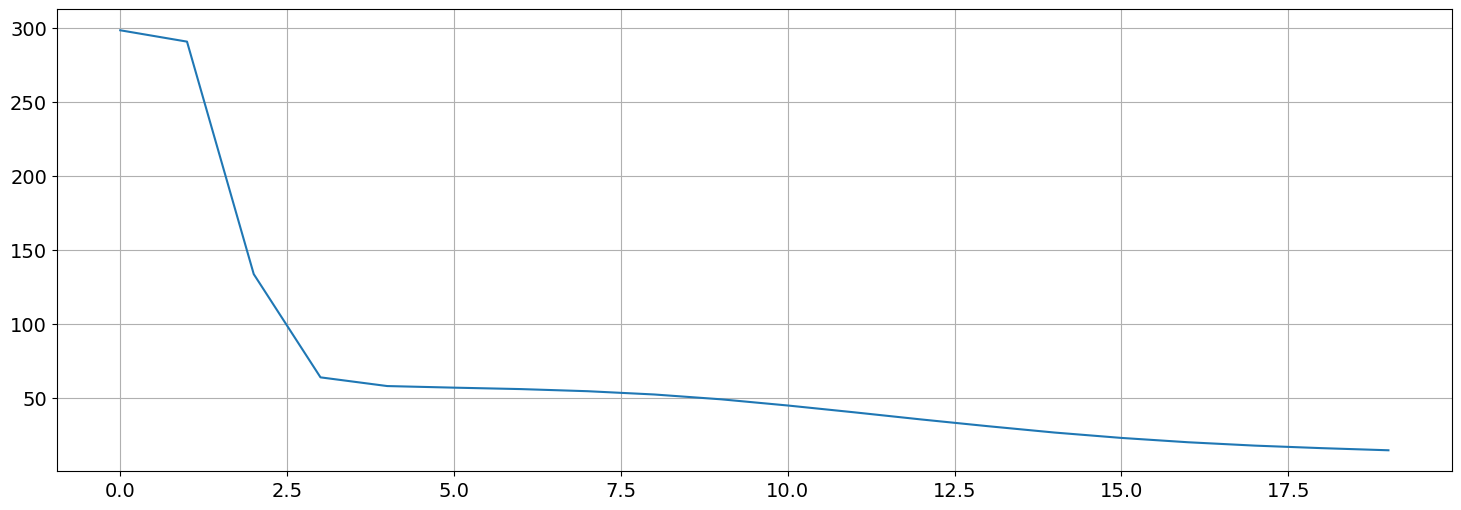

In [ ]:
# Function to provide data in batches
def get_batches(data, batch_size, shuffle=False):
    if shuffle:
        np.random.shuffle(data)
    if batch_size == -1:
        batch_size = len(data)
    num_batches = math.ceil(data.shape[0] / batch_size)
    for batch_num in range(num_batches):
        yield data[batch_num * batch_size:(batch_num + 1) * batch_size]

# Plotting functions (plot_images, plot_weights) remain unchanged

# Parameters for RBM
batch_size = 50
num_epochs = 20
lr = 0.1
burn_in = 0
num_steps = 1

# Assume RBM class is already implemented somewhere with methods like compute_error_and_grads and update_params
rbm = RBM(n_vis= 6, n_hid=40)

# Training loop
errors = []
start_time = time()

for epoch in range(1, num_epochs + 1):
    iteration = 0
    error = 0
    for batch in get_batches(dataset, batch_size, shuffle=True):
        iteration += 1
        error += rbm.compute_error_and_grads(batch, burn_in=burn_in, num_steps=num_steps)

        # Update parameters - use momentum
        if epoch > 5:
            rbm.update_params(lr, momentum=0.5)
        else:
            rbm.update_params(lr, momentum=0.9)

    print(f"epoch:{epoch} \t error:{error:.4f} \t training time:{time()-start_time:.2f} s")
    errors.append(error)

# Plot error
plt.plot(errors)
plt.savefig("error_plot")

## Generate Sample

In [ ]:
from collections import Counter

# Generate samples from the RBM after training
num_samples = 10000  # Number of samples to generate
samples = np.array([rbm.gen_model_sample() for _ in range(num_samples)])


# Count occurrences of each unique configuration
config_counter = Counter(tuple(samples) for samples in samples)

# Normalize the counts to get probabilities
rbm_approx_prob = {config: count / num_samples for config, count in config_counter.items()}
#print("Generated Samples: ", samples[:10])
#print("Approximate Probabilities: ", list(rbm_approx_prob.items())[:5])

## Plotting the approximated distribuition

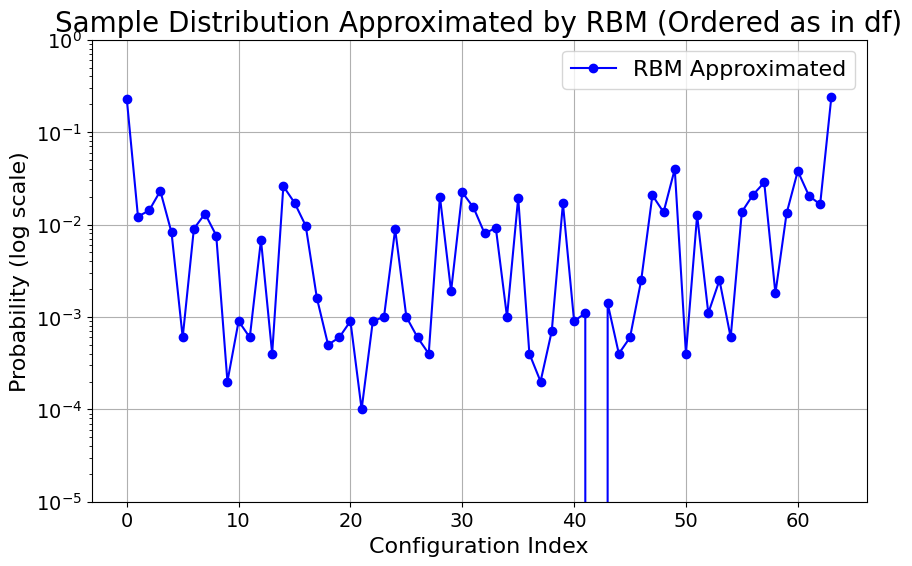

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming df['Configuration'] contains the ordered configurations and binary_configurations is already binarized
# Convert the configurations in df to tuples so they can be used for lookup in the RBM probabilities
ordered_configurations = [tuple(config) for config in df['Configuration'].tolist()]

# Convert the RBM learned distribution to arrays for plotting
# If a configuration doesn't exist in rbm_approx_prob, it gets a probability of 0
approx_probs = np.array([rbm_approx_prob.get(config, 0) for config in ordered_configurations])

# Plot the RBM learned distribution in the same order as df
plt.figure(figsize=(10, 6))

# Plot RBM approximated distribution
plt.plot(range(len(ordered_configurations)), approx_probs, marker='o', linestyle='-', color='blue', label='RBM Approximated')

# Set the y-axis to log scale for better visualization and limit from 10^0 to 10^-5
plt.yscale('log')
plt.ylim(1e-5, 1)

# Add title and labels
plt.title('Sample Distribution Approximated by RBM (Ordered as in df)')
plt.xlabel('Configuration Index')
plt.ylabel('Probability (log scale)')
plt.legend()

# Show the plot
plt.show()

# 2D Ising model for N = 3 x 3

We now extend our analysis to deal with the 2D Ising Model. Once again, we begin with considering a particular case. This time, we will focus on the N*N case. In extending this analysis for the 2D Ising model, the main change is that the interactions are no longer between nearest neighbors in a 1D chain but instead involve both vertical and horizontal neighbors on a 2D lattice. Ofcourse the problem scales terribly to be solved analytically. Just to give you the taste, if we solve this for N = 6 x 6 = 36 spins, we would have $2^36 = 68,719,476,736$ configurations. Far from ideal!

In [ ]:

# Define parameters
L = 3  # Lattice size (3x3 lattice)
J = 1  # Coupling constant
T = 1  # Temperature
N = L * L  # Total number of spins

# Generate all possible spin configurations for a 2D grid
# We generate all combinations of (-1, 1) for each spin in the grid
configurations = list(itertools.product([-1, 1], repeat=N))
print(f"Number of configurations: {len(configurations)}")  # 2^N configurations

# Function to convert a 1D configuration to a 2D grid (LxL)
def config_to_grid(config, L):
    return np.array(config).reshape(L, L)

# Hamiltonian function for 2D Ising model with periodic boundary conditions
def hamiltonian_2d_periodic(config, J, L):
    grid = config_to_grid(config, L)  # Convert 1D configuration to 2D grid
    energy = 0
    for i in range(L):
        for j in range(L):
            # Periodic boundary conditions
            # Interaction with right neighbor
            energy += grid[i, j] * grid[i, (j + 1) % L]
            # Interaction with bottom neighbor
            energy += grid[i, j] * grid[(i + 1) % L, j]
    return -J * energy

# Initialize lists for energies and Boltzmann factors
energies = []
boltzmann_factors = []

# Loop over each configuration
for config in configurations:
    # Compute the energy for the current configuration (2D periodic)
    energy = hamiltonian_2d_periodic(config, J, L)

    # Append the energy to the list
    energies.append(energy)

    # Compute the Boltzmann factor for the current energy
    boltzmann_factor = np.exp(-energy / T)

    # Append the Boltzmann factor to the list
    boltzmann_factors.append(boltzmann_factor)

# Convert lists to arrays for further computation
energies = np.array(energies)
boltzmann_factors = np.array(boltzmann_factors)

# Partition function Z
Z = np.sum(boltzmann_factors)

# Boltzmann probabilities for each configuration
probabilities = boltzmann_factors / Z

# Organize the result for better readability
results = []
for config, energy, prob in zip(configurations, energies, probabilities):
    results.append((config, energy, prob))

# Create a DataFrame for better visualization
df = pd.DataFrame(results, columns=['Configuration', 'Energy', 'Boltzmann Probability'])

# Output the DataFrame
print(df)

Number of configurations: 512
                            Configuration  Energy  Boltzmann Probability
0    (-1, -1, -1, -1, -1, -1, -1, -1, -1)     -18               0.498416
1     (-1, -1, -1, -1, -1, -1, -1, -1, 1)     -10               0.000167
2     (-1, -1, -1, -1, -1, -1, -1, 1, -1)     -10               0.000167
3      (-1, -1, -1, -1, -1, -1, -1, 1, 1)      -6               0.000003
4     (-1, -1, -1, -1, -1, -1, 1, -1, -1)     -10               0.000167
..                                    ...     ...                    ...
507          (1, 1, 1, 1, 1, 1, -1, 1, 1)     -10               0.000167
508         (1, 1, 1, 1, 1, 1, 1, -1, -1)      -6               0.000003
509          (1, 1, 1, 1, 1, 1, 1, -1, 1)     -10               0.000167
510          (1, 1, 1, 1, 1, 1, 1, 1, -1)     -10               0.000167
511           (1, 1, 1, 1, 1, 1, 1, 1, 1)     -18               0.498416

[512 rows x 3 columns]


## Plotting the 2D ising model for N = 3 x 3

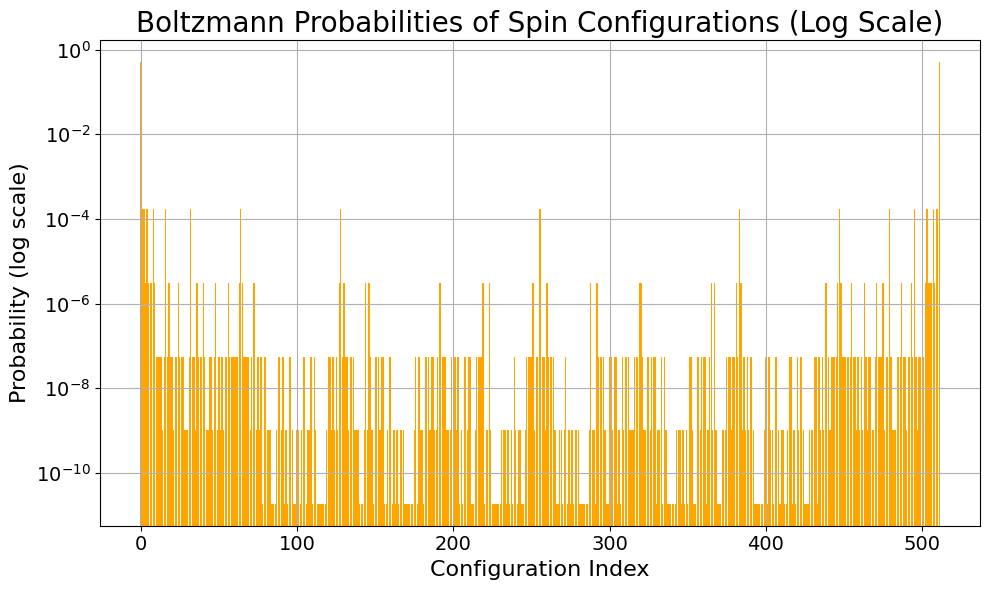

In [ ]:
# Plot the energies and corresponding Boltzmann probabilities on a log scale
plt.figure(figsize=(10, 6))

# Plot Boltzmann probabilities
plt.subplot(1, 1, 1)
plt.bar(range(len(probabilities)), probabilities, color='orange')
plt.yscale('log')  # Logarithmic scale for the probabilities
plt.title('Boltzmann Probabilities of Spin Configurations (Log Scale)')
plt.ylabel('Probability (log scale)')
plt.xlabel('Configuration Index')

# Show the plot
plt.tight_layout()
plt.show()

## Energy & Magnetization of 2D models

In [ ]:
import numpy as np

# Parameters
J = 1  # Coupling constant
L = 4  # Lattice size (LxL)

# Function to compute the total energy of a 2D Ising model using periodic boundary conditions
def energy(spin):
    """
    Computes the total energy of a 2D Ising model spin configuration using periodic boundary conditions.

    Parameters:
    - spin: 2D numpy array of spins (+1 or -1)

    Returns:
    - Total energy of the spin configuration
    """
    E = 0
    # Interaction with neighbors (right and bottom with periodic boundary conditions)
    for i in range(L):
        for j in range(L):
            S = spin[i, j]
            # Interaction with the right neighbor
            E += -J * S * spin[i, (j + 1) % L]
            # Interaction with the bottom neighbor
            E += -J * S * spin[(i + 1) % L, j]
    return E

# Function to compute the magnetization (sum of all spins) of a 2D Ising model
def magnetization(spin):
    """
    Computes the total magnetization of a 2D Ising model spin configuration.

    Parameters:
    - spin: 2D numpy array of spins (+1 or -1)

    Returns:
    - Total magnetization of the spin configuration
    """
    return np.sum(spin)

# Example 2D spin configurations
s1 = np.array([[1, 1, 1, 1],
               [1, 1, 1, 1],
               [1, 1, 1, 1],
               [1, 1, 1, 1]])

s2 = np.array([[1, -1, 1, -1],
               [-1, 1, -1, 1],
               [1, -1, 1, -1],
               [-1, 1, -1, 1]])

s3 = np.array([[1, 1, -1, -1],
               [1, 1, -1, -1],
               [-1, -1, 1, 1],
               [-1, -1, 1, 1]])

s4 = np.array([[-1, 1, -1, 1],
               [1, -1, 1, -1],
               [-1, 1, -1, 1],
               [1, -1, 1, -1]])

s5 = np.array([[-1, -1, -1, -1],
               [-1, -1, -1, -1],
               [-1, -1, -1, -1],
               [-1, -1, -1, -1]])

# Compute and print energies and magnetizations for each configuration
for idx, s in enumerate([s1, s2, s3, s4, s5], start=1):
    print(f"Energy for s{idx}: {energy(s)}")
    print(f"Magnetization for s{idx}: {magnetization(s)}")


Energy for s1: -32
Magnetization for s1: 16
Energy for s2: 32
Magnetization for s2: 0
Energy for s3: 0
Magnetization for s3: 0
Energy for s4: 32
Magnetization for s4: 0
Energy for s5: -32
Magnetization for s5: -16


## Metropolis

In [ ]:
# Generate a random lattice with probability p for spin +1
def randomLattice(L, p=0.5):
    return (np.random.rand(L, L) < p) * 2 - 1

In [ ]:
import numpy as np
import random

# Metropolis algorithm for 2D Ising model
def metropolis(spin_lattice, T):
    """
    Runs the Metropolis algorithm for one unit of Monte Carlo time (MCT)
    on a 2D spin lattice.

    Parameters:
    - spin_lattice: 2D numpy array of spins (+1 or -1)
    - T: Temperature

    Returns:
    - Updated spin lattice after one MCT step.
    """
    L = spin_lattice.shape[0]  # Lattice size (assumes square lattice)
    kB = 1.0  # Boltzmann constant (set to 1 for simplicity)

    for _ in range(L * L):  # L*L steps correspond to one MCT
        # Choose a random spin
        i, j = random.randint(0, L-1), random.randint(0, L-1)

        # Calculate the energy change if we flip this spin
        deltaE = 2 * spin_lattice[i, j] * (
            spin_lattice[i, (j + 1) % L] + spin_lattice[i, (j - 1) % L] +  # right and left neighbors
            spin_lattice[(i + 1) % L, j] + spin_lattice[(i - 1) % L, j]    # bottom and top neighbors
        )

        # Metropolis acceptance criterion
        if deltaE < 0 or random.random() < np.exp(-deltaE / (kB * T)):
            spin_lattice[i, j] *= -1  # Flip the spin

    return spin_lattice



In [ ]:
J = 1
kB = 1.0
L = 3
n = 1000                           # the number of MCT steps
p = 0.5                             # probability for the initial random lattice
T = 1 * J / kB                    # temp of the system in terms of coupling parameter and boltzmann constant
E = np.zeros( n )
M = np.zeros( n )
spinLattice = randomLattice( L, p )

#Run metropolis algo for N time steps and record energy, magnetic moments of each random lattice config
for i in range( n ) :
    spinLattice = metropolis( spinLattice, T )
    M[i] = magnetization( spinLattice )
    E[i] = energy( spinLattice )
    #print("energy is ", E[i])

## P(E) against E

system equilibriated


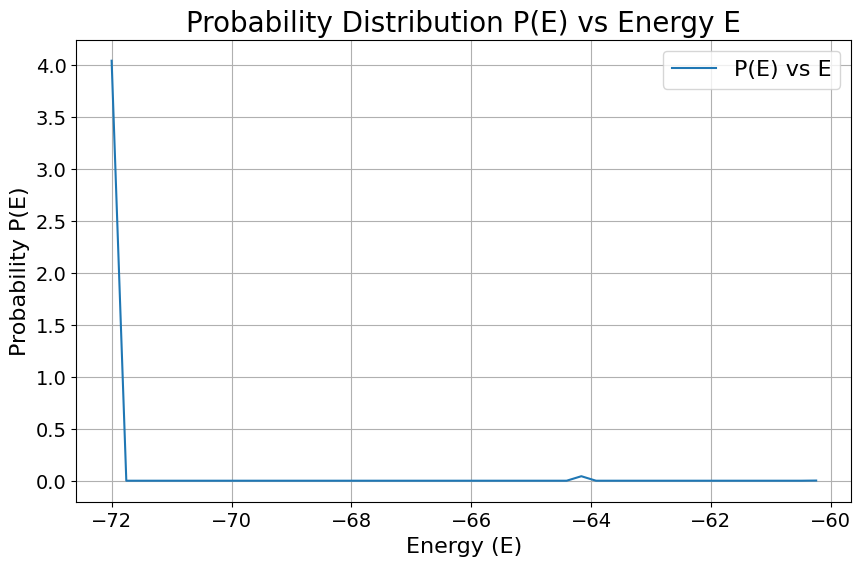

In [ ]:
p = 0.5          #probability for each particle to be spin-up (+1)
L = 6           # to see if the method is working for n = 6 for which we have
                 # the analytical case
J = 1.0          # gauge coupling parameter
kB = 1.0         # the Boltzman constant

n_equilibrate =  5000  # Number of steps for equilibration
n_samples = 10000      # Number of samples after equilibration

# Update the size of E and M to match the number of samples
E = np.zeros(n_samples)
M = np.zeros(n_samples)

# Equilibrate the system
spinLattice = randomLattice(L, p)
for _ in range(n_equilibrate):
    spinLattice = metropolis(spinLattice, T)

print("system equilibriated")

# Take samples after equilibration
for i in range(n_samples):
    spinLattice = metropolis(spinLattice, T)
    M[i] = magnetization(spinLattice)
    E[i] = energy(spinLattice)


# Probability distribution of P(E) against E

# Define bin edges for histogram
bins = np.linspace(min(E), max(E), 50)

# Create histogram for energy (P(E))
hist, bin_edges = np.histogram(E, bins=bins, density=True)

# Plot the probability distribution P(E) against energy E
plt.figure(figsize=(10, 6))
plt.plot(bin_edges[:-1], hist, label='P(E) vs E')
plt.xlabel('Energy (E)')
plt.ylabel('Probability P(E)')
plt.title('Probability Distribution P(E) vs Energy E')
plt.grid(True)
plt.legend()
plt.show()

## P(Configurations) vs Configurations

In [ ]:
import numpy as np
import random
from collections import defaultdict, Counter

# Define your metropolis, randomLattice, energy, and magnetization functions here...

# Example: Metropolis algorithm and tracking configurations for a 2D lattice
L = 6  # Lattice size (6x6 grid)
T = 1.0  # Temperature
n_equilibrate = 20000  # Number of steps for equilibration
n_samples = 10000  # Number of samples after equilibration

# Initialize defaultdict to count occurrences of each configuration
configurations = defaultdict(int)

# Initialize the spin lattice
spin_lattice = randomLattice(L, p=0.5)

# Equilibrate the system
for _ in range(n_equilibrate):
    spin_lattice = metropolis(spin_lattice, T)

# Record occurrences of each configuration
for _ in range(n_samples):
    spin_lattice = metropolis(spin_lattice, T)

    # Convert the 2D lattice into a 1D tuple to use as a dictionary key
    config_tuple = tuple(spin_lattice.flatten())

    # Update the count for this configuration
    configurations[config_tuple] += 1

# Convert to probability
total_configurations = sum(configurations.values())
probabilities = {config: count / total_configurations for config, count in configurations.items()}

# Print configurations and their probabilities (Optional)
for config, prob in probabilities.items():
    print(f"Configuration: {config}, Probability: {prob}")


Configuration: (-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1), Probability: 0.9867
Configuration: (-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1), Probability: 0.0005
Configuration: (-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1), Probability: 0.0001
Configuration: (-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1), Probability: 0.0013
Configuration: (-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1), Probability: 0.0001
Configuration: (-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -

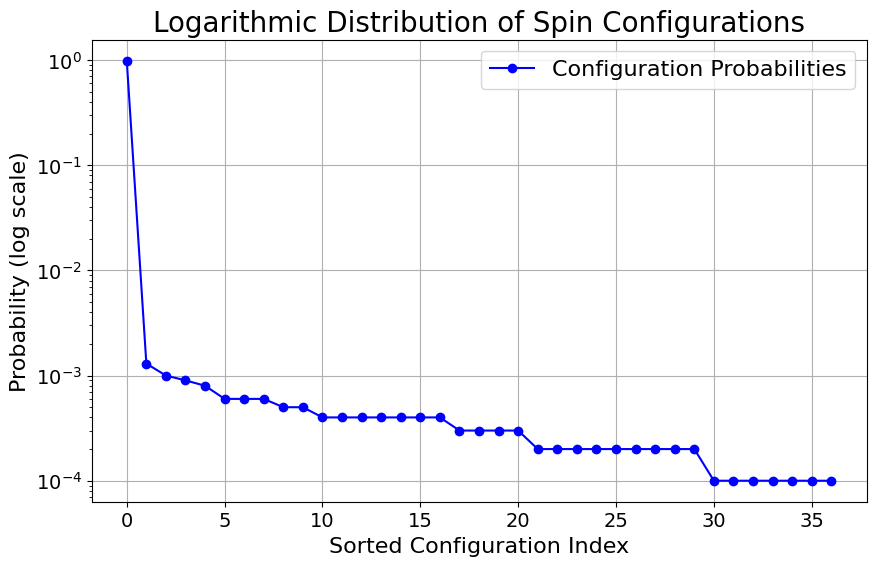

In [ ]:
# Convert to probability
total_configurations = sum(configurations.values())
probabilities = {config: count / total_configurations for config, count in configurations.items()}

# Plot configurations and their probabilities on a log scale
sorted_probs = sorted(probabilities.values(), reverse=True)  # Sort probabilities for better visualization

# Plot
plt.figure(figsize=(10, 6))
plt.plot(range(len(sorted_probs)), sorted_probs, marker='o', linestyle='-', color='blue', label='Configuration Probabilities')

# Set y-axis to logarithmic scale
plt.yscale('log')
plt.xlabel('Sorted Configuration Index')
plt.ylabel('Probability (log scale)')
plt.title('Logarithmic Distribution of Spin Configurations')
plt.grid(True)
plt.legend()
plt.show()

# Correlation Function

In [ ]:
def correlation(spin_all, N_corr):
    N_sample = spin_all.shape[0]
    N = spin_all.shape[1]
    corr = np.zeros(N_corr)
    ind = np.arange(0, N, int(N / N_corr))
    for i in np.arange(N_sample):
        for j in np.arange(N_corr):
            corr[j] += np.cos(spin_all[i, 0, ind[j]] - spin_all[i, 0, 0])
    corr = corr / N_sample
    return corr


# Calculate correlation function
corr = correlation(spin_all, N_corr)



# XY-model

The XY model is a classical model used in statistical mechanics to describe a system of spins that can rotate in a plane. It is a special case of the Heisenberg model where the spins are constrained to two dimensions (typically the x-y plane), rather than three-dimensional space.

In the XY model, each spin at lattice site $ i$ is a **two-dimensional unit vector** that can point in any direction in the plane. The angle of the spin $ \theta_i$ represents the direction of the vector, where:

$$
\mathbf{S}_i = \begin{pmatrix}
\cos \theta_i \\
\sin \theta_i
\end{pmatrix}
$$

Thus, the spin vector at each site is parameterized by an angle $\theta_i \in [0, 2\pi)$. Unlike the Ising model, where spins take discrete values $+1$ or $-1$, the spins in the XY model can vary continuously.

The **Hamiltonian** $H$ for the XY model describes the total energy of a system of spins. It includes contributions from the interactions between neighboring spins. The interaction energy between two neighboring spins $\mathbf{S}_i$ and $\mathbf{S}_j$ is typically taken as proportional to the **cosine of the angle difference** between them:

$$
H = -J \sum_{\langle i,j \rangle} \mathbf{S}_i \cdot \mathbf{S}_j = -J \sum_{\langle i,j \rangle} \cos(\theta_i - \theta_j)
$$

Where:
- $\langle i,j \rangle$ denotes a sum over nearest-neighbor pairs of spins on a lattice.
- $J$ is the **coupling constant**, which determines the strength of the interaction between spins.
  - $J > 0$ corresponds to **ferromagnetic** interactions (favoring aligned spins).
  - $J < 0$ corresponds to **antiferromagnetic** interactions (favoring anti-aligned spins).
- $\theta_i$ is the angle of the spin at site $i$.
- $\cos(\theta_i - \theta_j)$ describes how much the spins at $i$ and $j$ are aligned. The cosine function is maximized when $\theta_i = \theta_j$, meaning the spins are aligned.
